# eCommerce Analysis

### Dataset Information:
- This is a transnational data set which contains all the transactions occuring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occassion gifts. Many customers of the company are wholesalers.
- **Dataset Characteristics:** Multivariate, Sequential, Time-Series.
- **Number of Instances:** 5,41,909
- **Number of Attributes:** 08
- **Associated Tasks:** Classification, Clustering.

### Attribute Information:
- **InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicated a cancellation.
- **StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- **Description:** Product (item) name. Nominal.
- **Quantity:** The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice:** Unit price. Numeric, Product price per unit in sterling.
- **CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- **Country:** Country name. Nominal, the name of the country where each customer resides.

# Import Libraries

In [1]:
import datetime as dt
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pickle
from collections import Counter

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from altair import Chart, X, Y, Axis, SortField

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.1f}'.format

# from paretochart import pareto

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
### Load Dataset
data = pd.read_excel('/Users/ravivarma/DataScienceCode/ecommerce-website-data-analysis-master/Online Retail.xlsx')

In [3]:
### View top 3 rows of dataset
data.head(3)
### Check the Number of Instances(5,41,909 rows) and Attributes(8 columns)
#data.shape
### Check Data Types of Columns
#data.dtypes
data.info()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.4,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.8,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

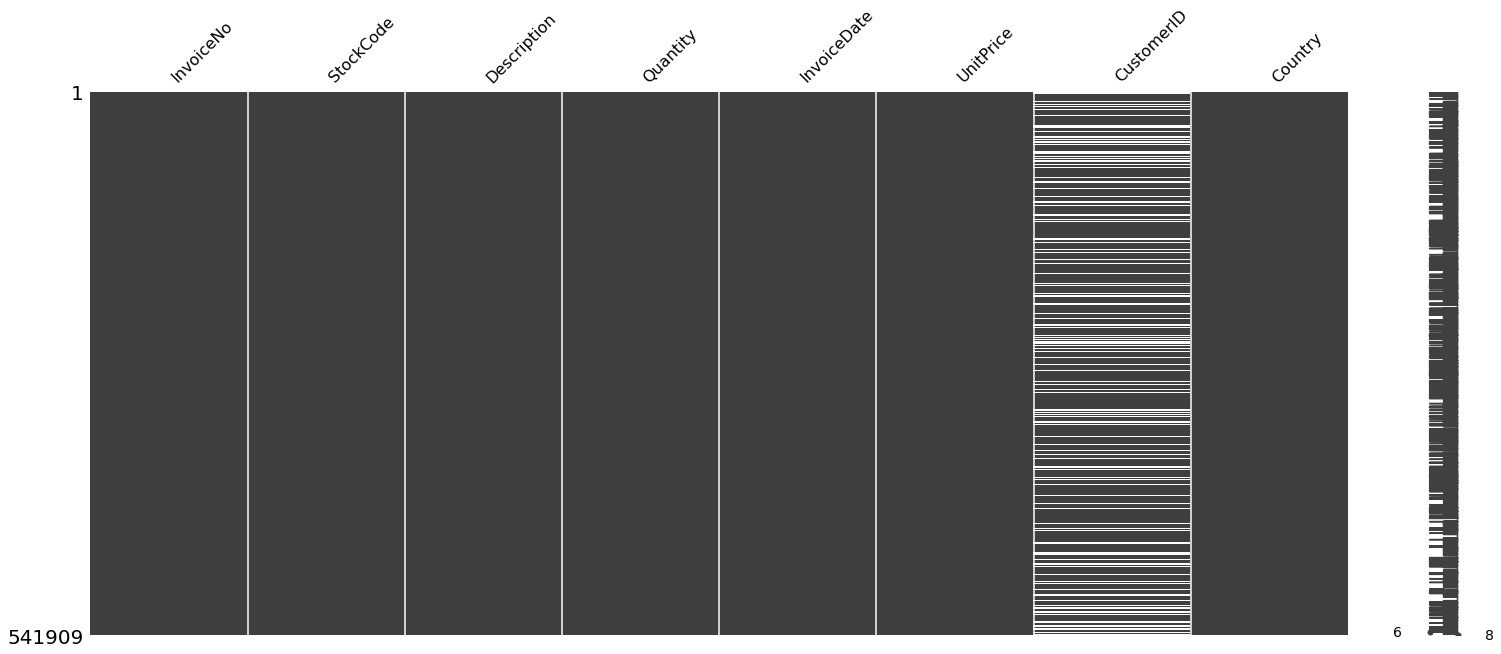

In [4]:
### A Cursory check for missing data:
msno.matrix(data)
### The dataset is missing some Description and CustomerID data entries.
data.isnull().sum()

In [5]:
### Check the missing values dataset shape.
# null_data = data[data.isnull().any(axis=1)]
# null_data.shape
print(data[data.isnull().any(axis=1)].shape)

### Check the % of the data contains missing values in dataset, which the figure above indicates is mostly nan values in CustomerID
# null_data_frac = null_data.shape[0]/data.shape[0]*100
# null_data_frac
print(data[data.isnull().any(axis=1)].shape[0]/data.shape[0]*100)

(135080, 8)
24.926694334288598


## Exploratory Data Analysis

#### The top 10 most popular items are sold in/to the UK. Apparently paper craft little birdie is very popular, along with medium ceramic top storage jar. I will remove the items with 'NaN' descriptor. These entries associated with nan CustomerID entries and 131 lower case descriptions which describe problems with the orders and no details of the item ordered. In addition, the data for United Kingdom contains negative values associated with negative UnitPrice values. Removing the rows containing NaN values therefore cleans several issues that complicate this analysis in the absence of the data owner.

In [6]:
data = data.sort_values('Quantity', ascending=False)
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.1,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.0,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom
74614,542504,37413,NaN,5568,2011-01-28 12:03:00,0.0,nan,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.2,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.7,13135.0,United Kingdom
220843,556231,85123A,?,4000,2011-06-09 15:04:00,0.0,nan,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.8,18087.0,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.1,14609.0,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.1,15749.0,United Kingdom


In [7]:
### Remove NaN values in Dataset
#data[data.isnull()] #541909 rows × 8 columns
#data[data.isnull().any(axis=1)] #135080 rows × 8 columns
data = data.dropna()
data.shape # 541909 - 406829 = dropped 135080 entries

(406829, 8)

In [8]:
### Check for Duplicate entries and remove those.
#data[data.duplicated(keep=False)].sort_values("CustomerID") #10062 rows × 8 columns
#data[data.duplicated() == True].sort_values("CustomerID") #5225 rows × 8 columns
data.drop_duplicates(inplace = True)
data.shape # 406829 - 401604 = dropped 5225 duplicate entries

(401604, 8)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

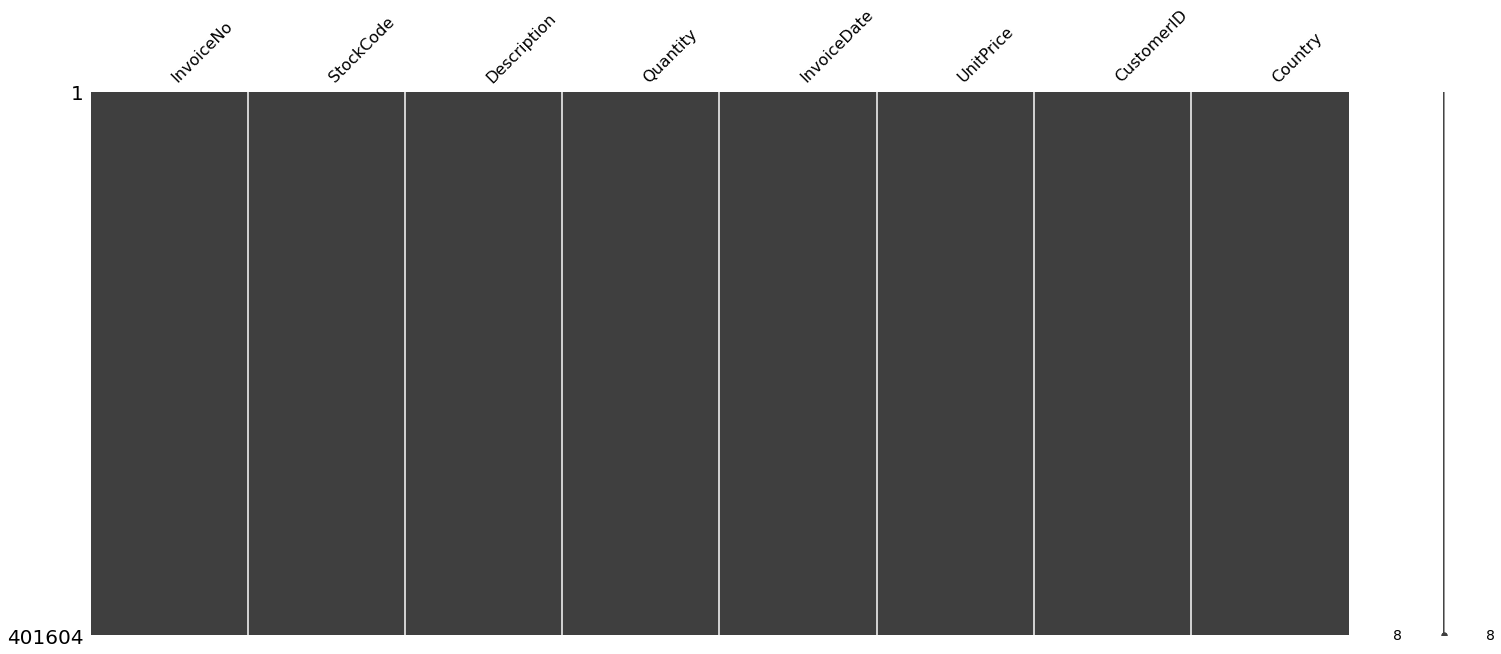

In [9]:
### We now have no missing values and have removed assumed erroneous results and duplicates entries.
### A Cursory check for missing data:
msno.matrix(data)
### The dataset is missing some Description and CustomerID data entries.
data.isnull().sum()

## Further Exploration and Trend Analysis
### How many unique descriptors are there in "Descriptions"?

In [10]:
### General Clean up of Description column to remove any heading or trailing white space
data['Description'] = data['Description'].str.strip()
descriptors = pd.unique(data['Description'].values.ravel()).tolist()
print('There are', len(descriptors), 'unique descriptors in the Descriptions column.')

There are 3885 unique descriptors in the Descriptions column.


In [11]:
descriptors2 = []
for i in range(0,len(descriptors),1):
    text = str(descriptors[i])
    if text == text.upper():
        descriptors2.append(text)
        
print('There are', len(descriptors2), 'all caps descriptors.')

There are 3862 all caps descriptors.


In [12]:
### From inspection of the baskets below I identified 3 problem descriptors that need to be followed up.
additional_problem_list = ['damages/credits from ASOS.','incorrectly credited C550456 see 47', 'mystery! Only ever imported 1800']

In [13]:
### Remove additional erroneous rows
#data[~data['Description'].isin(additional_problem_list)]
data = data[~data['Description'].isin(additional_problem_list)]

In [14]:
data.shape

(401604, 8)

In [15]:
InvoiceNo = pd.unique(data['InvoiceNo'].values.ravel()).tolist()
print('There are', len(InvoiceNo), 'unique invoice numbers in the dataset.')

There are 22190 unique invoice numbers in the dataset.


### Group by Country

In [16]:
by_country = data.groupby('Country')
by_country.describe()

Quantity                                               \
                        count mean   std      min   25%  50%   75%     max   
Country                                                                      
Australia              1258.0 66.5  97.7   -120.0   6.0 24.0  96.0  1152.0   
Austria                 401.0 12.0  21.7    -48.0   6.0  9.0  12.0   288.0   
Bahrain                  17.0 15.3  25.0      2.0   6.0  6.0   8.0    96.0   
Belgium                2069.0 11.2  13.6    -12.0   4.0 10.0  12.0   272.0   
Brazil                   32.0 11.1   8.5      2.0   3.0 10.0  18.0    24.0   
Canada                  151.0 18.3  46.7      1.0   6.0 12.0  20.0   504.0   
Channel Islands         757.0 12.5  22.6     -2.0   4.0 10.0  12.0   407.0   
Cyprus                  611.0 10.3  23.4    -33.0   2.0  5.0  12.0   288.0   
Czech Republic           30.0 19.7  22.8    -24.0  12.0 24.0  24.0    72.0   
Denmark                 389.0 21.0  27.4    -25.0  12.0 12.0  24.0   256.0   
EIRE                   7475.0 18.2  42.0   -288.0   4.0 10.0  12.0  1440.0   
European Community       61.0  8.1   6.5     -2.0   3.0  6.0  12.0    24.0   
Finland                 695.0 15.3  21.0    -27.0   6.0 10.0  12.0   144.0   
France                 8475.0 13.0  21.5   -250.0   5.0 10.0  12.0   912.0   
Germany                9480.0 12.4  17.9   -288.0   5.0 10.0  12.0   600.0   
Greece                  146.0 10.7   7.7     -1.0   5.2 10.0  12.0    48.0   
Iceland                 182.0 13.5  18.9      2.0   6.0 12.0  12.0   240.0   
Israel                  247.0 16.1  16.7    -32.0   4.0 12.0  24.0   100.0   
Italy                   803.0 10.0  13.6    -12.0   4.0  6.0  12.0   200.0   
Japan                   358.0 70.4 177.2   -624.0   4.0 36.0  72.0  2040.0   
Lebanon                  45.0  8.6   4.3      2.0   6.0  8.0  12.0    24.0   
Lithuania                35.0 18.6  10.1      6.0  12.0 16.0  24.0    48.0   
Malta                   127.0  7.4   8.1     -4.0   3.0  6.0  12.0    48.0   
Netherlands            2371.0 84.4 111.4   -480.0  16.0 72.0 100.0  2400.0   
Norway                 1086.0 17.7  22.6    -12.0   6.0 12.0  24.0   240.0   
Poland                  341.0 10.7  10.2     -6.0   4.0 10.0  12.0    72.0   
Portugal               1471.0 10.9  11.9    -12.0   4.0 10.0  12.0   120.0   
RSA                      58.0  6.1   3.3      1.0   3.0  6.0   9.5    12.0   
Saudi Arabia             10.0  7.5   5.7     -5.0   6.0  9.0  12.0    12.0   
Singapore               229.0 22.9  27.7     -1.0   8.0 12.0  24.0   288.0   
Spain                  2528.0 10.6  24.2   -288.0   3.0  6.0  12.0   360.0   
Sweden                  461.0 77.3 129.0   -240.0   8.0 20.0  96.0   768.0   
Switzerland            1877.0 15.9  19.3   -120.0   6.0 12.0  24.0   288.0   
USA                     291.0  3.6  16.5    -36.0 -10.0  5.0  12.0    72.0   
United Arab Emirates     68.0 14.4  12.5      1.0   6.0 12.0  12.0    72.0   
United Kingdom       356728.0 11.2 265.0 -80995.0   2.0  4.0  12.0 80995.0   
Unspecified             241.0  7.4   8.9      1.0   1.0  2.0  12.0    36.0   

                     UnitPrice                                     CustomerID  \
                         count  mean   std min 25% 50% 75%     max      count   
Country                                                                         
Australia               1258.0   3.2  12.5 0.0 1.2 1.8 3.8   350.0     1258.0   
Austria                  401.0   4.2   7.4 0.1 1.2 1.9 4.2    40.0      401.0   
Bahrain                   17.0   4.6   3.7 1.2 1.6 3.0 5.0    12.8       17.0   
Belgium                 2069.0   3.6   4.2 0.1 1.2 1.9 4.2    40.0     2069.0   
Brazil                    32.0   4.5   2.8 0.8 2.0 3.3 6.8    10.9       32.0   
Canada                   151.0   6.0  44.7 0.1 0.8 1.6 3.0   550.9      151.0   
Channel Islands          757.0   4.9  15.6 0.2 1.4 2.5 6.2   293.0      757.0   
Cyprus                   611.0   6.4  22.6 0.1 1.2 3.0 5.0   320.7      611.0   
Czech Rep

In [17]:
grouped  = data.groupby(['Country']).sum()['Quantity'].sort_values(ascending=False)

data_plot = [go.Bar(x=grouped.index, y=grouped.values)]
layout = go.Layout(yaxis={'type':'log', 'autorange':True, 'title':'Log10 number of orders'},xaxis={'title':'country'})
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

In [18]:
### The United Kingdom purchases the majority of products by almost 2 orders of magnitude.
### group by customer ID and invoice number to create a basket per customer
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
products_per_basket[:10].sort_values('Number of products', ascending=False)

,CustomerID,InvoiceNo,Number of products
7,12347.0,573511,47
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
6,12347.0,562032,22
5,12347.0,556201,18
9,12348.0,539318,17
8,12347.0,581180,11
0,12346.0,541431,1
1,12346.0,C541433,1


In [19]:
### There are InvoiceNo entries beginning with the character C.
print('There are:',data['InvoiceNo'].str.contains("C").sum(), 'orders marked C, which contribute',(data['InvoiceNo'].str.contains("C").sum()/len(data))*100, '% of the dataset.')
data[data.InvoiceNo.str.contains('C', case=False, na=False)]


There are: 8872 orders marked C, which contribute 2.209141343213713 % of the dataset.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
268308,C560408,M,Manual,-1,2011-07-18 14:24:00,550.6,13564.0,United Kingdom
186013,C552841,22838,3 TIER CAKE TIN RED AND CREAM,-1,2011-05-11 14:28:00,14.9,15827.0,United Kingdom
169480,C551175,22325,MOBILE VINTAGE HEARTS,-1,2011-04-26 17:17:00,5.0,14329.0,United Kingdom
429996,C573575,CRUK,CRUK Commission,-1,2011-10-31 14:09:00,606.0,14096.0,United Kingdom
281674,C561591,22768,FAMILY PHOTO FRAME CORNICE,-1,2011-07-28 11:17:00,9.9,15708.0,United Kingdom
...,...,...,...,...,...,...,...,...
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.9,15749.0,United Kingdom
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.1,15749.0,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.0,15838.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.0,12346.0,United Kingdom


In [20]:
### Select all the cancelled orders
cancelled_orders = data[data.InvoiceNo.str.contains('C', case=False, na=False)]
cancelled_orders.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
268308,C560408,M,Manual,-1,2011-07-18 14:24:00,550.6,13564.0,United Kingdom
186013,C552841,22838,3 TIER CAKE TIN RED AND CREAM,-1,2011-05-11 14:28:00,14.9,15827.0,United Kingdom
169480,C551175,22325,MOBILE VINTAGE HEARTS,-1,2011-04-26 17:17:00,5.0,14329.0,United Kingdom
429996,C573575,CRUK,CRUK Commission,-1,2011-10-31 14:09:00,606.0,14096.0,United Kingdom
281674,C561591,22768,FAMILY PHOTO FRAME CORNICE,-1,2011-07-28 11:17:00,9.9,15708.0,United Kingdom
268312,C560409,84078A,SET/4 WHITE RETRO STORAGE CUBES,-1,2011-07-18 14:24:00,40.0,16717.0,United Kingdom
355585,C567947,23234,BISCUIT TIN VINTAGE CHRISTMAS,-1,2011-09-23 08:00:00,2.9,17663.0,United Kingdom
355584,C567947,21201,TROPICAL HONEYCOMB PAPER GARLAND,-1,2011-09-23 08:00:00,2.5,17663.0,United Kingdom
96677,C544577,M,Manual,-1,2011-02-21 14:02:00,320.7,12365.0,Cyprus
45144,C540250,21928,JUMBO BAG SCANDINAVIAN PAISLEY,-1,2011-01-05 16:02:00,1.6,17511.0,United Kingdom


In [21]:
c1_tmp = pd.DataFrame(cancelled_orders['InvoiceNo'])
c2_tmp = cancelled_orders['InvoiceNo'].str.extract('(\d+)').astype(int)
c1_tmp['invoice2'] = c2_tmp

In [22]:
### InvoiceNo containing a "C" character correspond with a negative Quantity value, 
### therefore I will assume these are cancelled orders. For the purposes of this report I am going to 
### remove cancelled orders from consideration.

data = data[~data['InvoiceNo'].isin(c1_tmp['InvoiceNo'])]
data = data[~data['InvoiceNo'].isin(c1_tmp['invoice2'])]

In [ ]:
### Note There was an error in the test submission. Order numbers prefixed with 'C' where removed 
### but this leaves the original order number in the dataset. For completeness, I have updated this 
### script to remove the order that corresponds with the canceled order as well
#data = data[~data['InvoiceNo'].str.contains('C', case=False, na=False)]

### Investigation of top CustomerID basket

In [23]:
### group by customer ID to create a rank buyers by how many products they buy in total.
temp = data.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
top_baskets = products_per_basket.sort_values('Number of products', ascending=False)
top_baskets.head(10)
### Top customer purchased 7667 products in the largest basket.

,CustomerID,Number of products
4011,17841.0,7676
1880,14911.0,5672
1290,14096.0,5111
326,12748.0,4413
1662,14606.0,2677
2177,15311.0,2366
1690,14646.0,2080
562,13089.0,1814
691,13263.0,1667
1435,14298.0,1637


In [24]:
grouped = top_baskets[:50]
grouped.reset_index(level=0, inplace=True)
grouped.sort_values('Number of products', ascending=False, inplace=True)
grouped['CustomerID'] = grouped['CustomerID'].astype(str)

/Volumes/RaviVarma/DataScience/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Volumes/RaviVarma/DataScience/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
data_plot = [go.Bar(x=grouped['CustomerID'], y=grouped['Number of products'])]
layout = go.Layout(yaxis={'autorange':True,'title':'Number of products in basket'},xaxis={'type':'category','title':'Customer ID'},title = 'Number of Products Bought in the Top 50 Largest Baskets')
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

In [26]:
top_basket = data[data['CustomerID'] == top_baskets['CustomerID'].iloc[0]]
### top_basket #uncomment to view basket contents
### Note - this investigation was used with apriori modeling detailed in the Addendum section.

### Investigation of StockCode
- There are some non-integer values in StockCodes which correspond with order descriptions that are not items.

In [27]:
data[~data.StockCode.str.contains('[0-9]', case=True, na=True)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
490502,578060,M,Manual,1600,2011-11-22 15:22:00,0.2,17857.0,United Kingdom
452218,575328,M,Manual,1200,2011-11-09 13:48:00,0.2,17857.0,United Kingdom
437235,574277,M,Manual,832,2011-11-03 14:42:00,0.2,17857.0,United Kingdom
526018,580646,M,Manual,800,2011-12-05 13:13:00,0.2,17857.0,United Kingdom
414138,572344,M,Manual,456,2011-10-24 10:43:00,1.5,14607.0,United Kingdom
...,...,...,...,...,...,...,...,...
393771,570851,POST,POSTAGE,1,2011-10-12 14:46:00,18.0,12583.0,France
392929,570754,POST,POSTAGE,1,2011-10-12 11:40:00,18.0,12633.0,Germany
392978,570784,POST,POSTAGE,1,2011-10-12 11:49:00,18.0,12569.0,Germany
392884,570725,POST,POSTAGE,1,2011-10-12 11:30:00,4.5,12381.0,Norway


In [28]:
#data[~data.StockCode.str.contains('[0-9]', case=True, na=True)]
mask = (~data['StockCode'].str.contains('[0-9]', case=True, na=True))
odd_stock_codes = data.loc[mask] #filter out any stock codes that are numeric to leave the non-standard codes
odd_stock_codes.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
490502,578060,M,Manual,1600,2011-11-22 15:22:00,0.2,17857.0,United Kingdom
452218,575328,M,Manual,1200,2011-11-09 13:48:00,0.2,17857.0,United Kingdom
437235,574277,M,Manual,832,2011-11-03 14:42:00,0.2,17857.0,United Kingdom
526018,580646,M,Manual,800,2011-12-05 13:13:00,0.2,17857.0,United Kingdom
414138,572344,M,Manual,456,2011-10-24 10:43:00,1.5,14607.0,United Kingdom


In [29]:
odd_stock_codes['StockCode'].unique(), print('total number of these short stock code entries:',len(odd_stock_codes))

total number of these short stock code entries: 1416


(array(['M', 'POST', 'DOT', 'BANK CHARGES', 'PADS'], dtype=object), None)

In [30]:
### As the number of non-standard stock codes is small, for the purposes of this report they will be deleted 
### From the dataset.
#data.loc[~mask]
data = data.loc[~mask]
### During the data cleaning process NaN, duplicate entries, cancelled invoices, and miscellaneous 
### Stock codes have been removed.

## Feature Engineering
- Moving on from exploratory data analysis, are there any features that can be created in order to categorize/cluster aspects of the data and aid machine learning?

In [31]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.1,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.0,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.2,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.7,13135.0,United Kingdom


### Investigating the total amount spent per customers

In [32]:
total_spend = data['Quantity'] * data['UnitPrice']

In [33]:
data = data.assign(total_spend=total_spend.values)

In [34]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.1,16446.0,United Kingdom,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.0,12346.0,United Kingdom,77183.6
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,0.0
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.2,12901.0,United Kingdom,1008.0
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.7,13135.0,United Kingdom,3096.0


### Grouped per Country

In [35]:
grouped = data.groupby(['Country']).sum()['total_spend'].sort_values(ascending=False)

In [36]:
data_plot = [go.Bar(x=grouped.index, y=grouped.values)]
layout = go.Layout(yaxis={'autorange':True, 'title':'Total Order Expenditure'},xaxis={'title':'Country'},title="Total Spend per Country")
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

### Grouped per Customer
- Identify the top purchasers

In [37]:
grouped  = data.groupby(['CustomerID']).sum()['total_spend'].sort_values(ascending=False)
grouped_top = pd.DataFrame(grouped.head(50))
grouped_top.reset_index(level=0, inplace=True)
grouped_top.sort_values('CustomerID', ascending=False)

data_plot = [go.Bar(x=grouped_top['CustomerID'], y=grouped_top['total_spend'])]
layout = go.Layout(yaxis={'autorange':True,'title':'Top 50 customers'},xaxis={'type':'category','title':'Total Expenditure'},title='Top Purchasers')
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

,CustomerID,total_spend
1,18102.0,259657.3
14,17949.0,58030.5
37,17857.0,25301.5
22,17841.0,40496.0
40,17675.0,20374.3
7,17511.0,91062.4
2,17450.0,194390.8
48,17428.0,17256.9
29,17404.0,31781.8
28,17389.0,31833.7


### Calculate the top 50 largest baskets, in terms of total spend

In [38]:
top_50 = data[data['CustomerID'].isin(grouped_top['CustomerID'])]
top_50.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.1,16446.0,United Kingdom,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.0,12346.0,United Kingdom,77183.6
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.2,12901.0,United Kingdom,1008.0
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.1,15749.0,United Kingdom,6539.4
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.1,15749.0,United Kingdom,6539.4


### Locate the country of origin of the top 50 biggest spenders

In [39]:

top50_tmp  = top_50.groupby(['Country']).sum()['total_spend'].sort_values(ascending=False)

top50_tmp = pd.DataFrame(top50_tmp)
top50_tmp.reset_index(level=0, inplace=True)
top50_tmp.sort_values('Country', ascending=False)

data_plot = [go.Bar(x=top50_tmp['Country'], y=top50_tmp['total_spend'])]
layout = go.Layout(yaxis={'autorange':True,'title':'Total Expenditure'},xaxis={'type':'category','title':'country'},title='Top 50 Biggest Spenders')
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

,Country,total_spend
0,United Kingdom,2173305.6
4,Sweden,31781.8
1,Netherlands,279138.0
5,Japan,21429.4
7,Germany,17388.6
6,France,18751.9
2,EIRE,257546.9
3,Australia,124564.5


### Classify customers based on total spend
- Collate all the purchases made during a single order to calculate the total order value:

In [40]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['total_spend'].sum()
basket_price = temp.rename(columns = {'total_spend':'Basket value'})

In [41]:
### Top 10 baskets
basket_price.head(10)

,CustomerID,InvoiceNo,Basket value
0,12346.0,541431,77183.6
1,12347.0,537626,711.8
2,12347.0,542237,475.4
3,12347.0,549222,636.2
4,12347.0,556201,382.5
5,12347.0,562032,584.9
6,12347.0,573511,1294.3
7,12347.0,581180,224.8
8,12348.0,539318,652.8
9,12348.0,541998,187.4


In [42]:
tmp = basket_price
tmp = pd.DataFrame(tmp)
tmp.reset_index(level=0, inplace=True)
tmp.sort_values('Basket value', ascending=False)

data4plot = [go.Histogram(x=tmp['Basket value'][:100])]

iplot(data4plot)

,index,CustomerID,InvoiceNo,Basket value
12783,12783,16446.0,581483,168469.6
0,0,12346.0,541431,77183.6
8941,8941,15098.0,556444,38970.0
15747,15747,17450.0,567423,31698.2
158,158,12415.0,556917,22775.9
...,...,...,...,...
7759,7759,14744.0,542736,0.6
7899,7899,14800.0,570554,0.4
7355,7355,14646.0,564651,0.0
3098,3098,13256.0,578841,0.0


#### The distribution of basket is somewhat bimodal. This histogram of basket values indicates a large number of low total value baskets and a small number of individual orders totaling high value baskets. This observation can be used to bin customers into those spending small amounts, medium amounts, and high value baskets (note the bimodal distribution above may cause an imbalance problem for machine learning):

In [43]:
spend_label = []
for i in range(0,len(data),1):
    if data['total_spend'].iloc[i] < 5000:
        spend_label.append(1)
    elif data['total_spend'].iloc[i] >50000:
        spend_label.append(3)
    else:
        spend_label.append(2)

In [44]:
data['spend_label'] = spend_label

In [45]:
len(data.StockCode.unique()), len(data.Description.unique())

(3660, 3861)

In [46]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,spend_label
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.1,16446.0,United Kingdom,168469.6,3
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.0,12346.0,United Kingdom,77183.6,3
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,0.0,1
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.2,12901.0,United Kingdom,1008.0,1
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.7,13135.0,United Kingdom,3096.0,1


In [47]:
### Save the Cleaned Dataset into a Pickle file.
pickle.dump(data, open( "clean_data.pkl", "wb" ))

## Clustering
### Group by CustomerID
- group by CustomerID, together with sum or number of items (quantity) and the unit price

In [48]:
data_grouped = data.groupby('CustomerID')
data_cluster=pd.DataFrame(columns=['Quantity','UnitPrice', 'total_spend', 'CustomerID'])
count=0

In [ ]:
# data_grouped.head(5)

In [49]:
for k,v in (data_grouped):
    data_cluster.loc[count] = [(v['Quantity'].sum()), v['UnitPrice'].sum(), v['total_spend'].sum(), k]
    count+=1

### Applying K-Means Clustering Algorithm to quantity, and total spend
X = data_cluster.iloc[:, [0, 2]].values

In [50]:
data_cluster.head()

,Quantity,UnitPrice,total_spend,CustomerID
0,74215.0,1.0,77183.6,12346.0
1,2458.0,481.2,4310.0,12347.0
2,2332.0,18.7,1437.2,12348.0
3,630.0,305.1,1457.5,12349.0
4,196.0,25.3,294.4,12350.0


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Text(0.5, 1.0, 'The Elbow Method')

Text(0.5, 0, 'Number Of Customer Clusters(customer type clusters)')

Text(0, 0.5, 'Within cluster sum of squares (WCSS)')

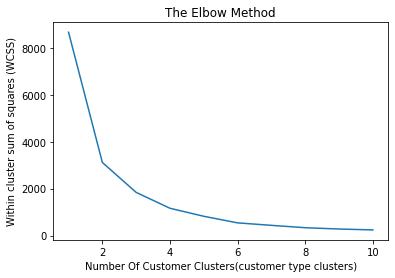

In [51]:
### Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X= sc_X.fit_transform(X)

### Using the Elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = [] #Within cluster sum of squares (inertia)

for i in range(1,11): ### From 2-10 doing multiple random initializations can make a huge difference to find a better local optimal
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('Within cluster sum of squares (WCSS)')
plt.show()

Text(0.5, 1.0, 'Type Of Customers(customer type clusters)')

Text(0.5, 0, 'Number of items Purchased (Quantity)')

Text(0, 0.5, 'basket total spend')

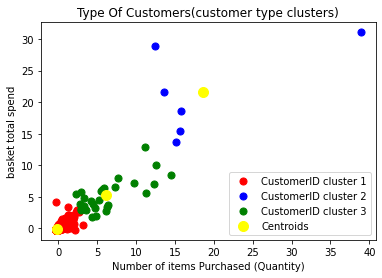

In [52]:
### Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

### Visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 50, c = 'red', label = 'CustomerID cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 50, c = 'blue', label = 'CustomerID cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 50, c = 'green', label = 'CustomerID cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Type Of Customers(customer type clusters)')
plt.xlabel('Number of items Purchased (Quantity)')
plt.ylabel('basket total spend')
plt.legend()
plt.show()

#### Clustering appears to separate the customers based on numbers of items and total spend, which would be expected

## Modelling
### Machine Learning Data Preparation

In [2]:
### Load the Cleaned Dataset back from the pickle file.
data = pickle.load(open( "clean_data.pkl", "rb" ))

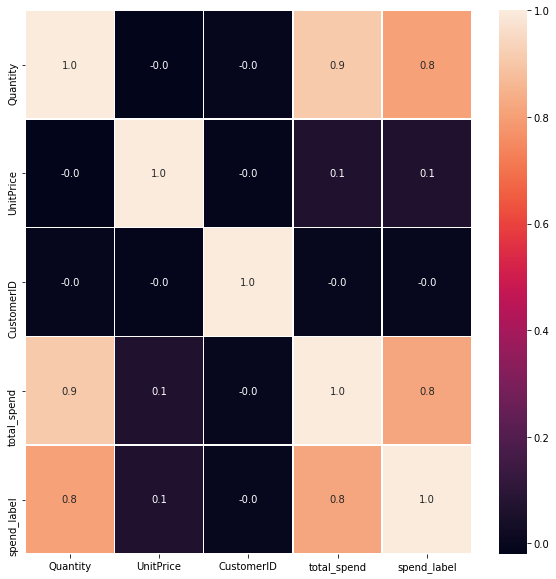

In [3]:
### A cursory examination of correlation to identify potentially problematic variables from the model training dataset.
### Heat Map to look for correlation
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

#### Unsurprisingly, total spend correlates with quantity and the spend_label. Potentially, quantity or total spend may have to be removed for training.

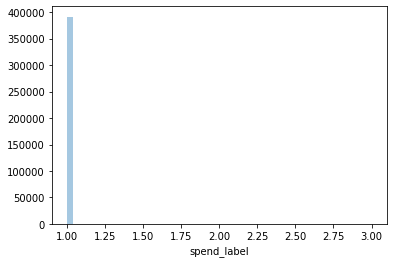

In [4]:
sns.distplot(data['spend_label'],kde = False)
plt.show()

#### This data is very imbalanced. For the purposes of this investigation the lower value baskets will be used for prediction.
#### Below I will identify a range suitable for binning:

In [5]:
data2 = data[(data['total_spend'] >0) & (data['total_spend'] < 100)]

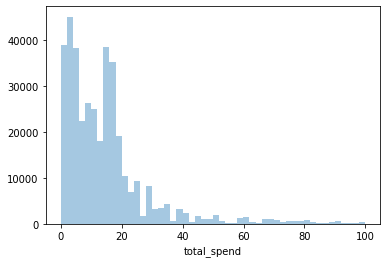

In [6]:
sns.distplot(data2['total_spend'],kde = False)
plt.show()

#### Here we are repeating the labeling of total spend from low (0), medium (1), and high (2), but with the lower range of values.

In [7]:
spend_label = []
for i in range(0,len(data2),1):
    if data2['total_spend'].iloc[i] < 10:
        spend_label.append(0)
    elif data2['total_spend'].iloc[i] >40:
        spend_label.append(2)
    else:
        spend_label.append(1)

#### Numerical labels represent 0 - low value baskets, 1 - medium value baskets, 3 - higher value baskets.

In [8]:
data2['spend_label'] = spend_label

/Volumes/RaviVarma/DataScience/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
data2.shape ### There is still a reasonably large sized data set to work with

(379870, 10)

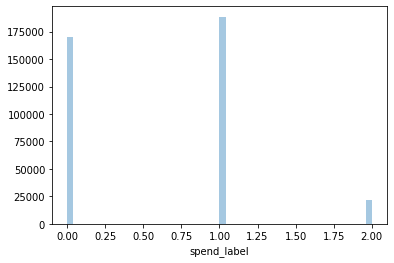

In [10]:
sns.distplot(data2['spend_label'],kde = False)
plt.show()

#### The data is still unbalanced in terms of representation from high value baskets, but more balanced than the full dataset
### Create dummy variables from the string columns (descriptions and country)

In [11]:
### Encode the description label
cols_to_transform = ['Description']
type_hash = pd.get_dummies(data=data2['Description'])
type_hash2 = pd.get_dummies(data=data2['Country'])

In [12]:
learning_data = pd.concat([data2, type_hash, type_hash2], axis=1)

In [13]:
### Drop the columns that have been now been replaced and that are not required
droplist = ['Quantity','StockCode','InvoiceDate','InvoiceNo','UnitPrice','Description','Country','CustomerID']
learning_data = learning_data.drop(droplist, axis=1)

In [14]:
learning_data = learning_data.reset_index(drop=True)

In [15]:
xdata = learning_data.copy()
del xdata['spend_label']
ydata = learning_data['spend_label']

In [16]:
normalized_xdata = preprocessing.normalize(xdata)

In [17]:
scaler = StandardScaler()
scaler.fit(normalized_xdata[:20000])

pca = decomposition.PCA(n_components=5)
pc = pca.fit_transform(normalized_xdata[:20000]) ### PCA is being performed on the 1st 100000 data points due to limited computer resource

pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2','PC3','PC4', 'PC5'])
pc_df.head()

StandardScaler(copy=True, with_mean=True, with_std=True)

,PC1,PC2,PC3,PC4,PC5
0,-0.0,-0.0,-0.0,-0.0,0.0
1,-0.0,-0.0,-0.0,-0.0,0.0
2,-0.0,-0.0,-0.0,-0.0,0.0
3,-0.0,0.0,-0.0,-0.0,0.0
4,-0.0,-0.0,-0.0,-0.0,0.0


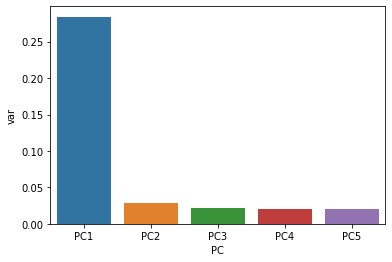

In [18]:
### Plot the Variance
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4', 'PC5']})
sns.barplot(x='PC',y="var", 
           data=df);

In [19]:
scaler = StandardScaler()
scaler.fit(xdata[:20000])
X=scaler.transform(xdata[:20000])

pca = PCA(n_components=2)
pca.fit(X,ydata)
x_new = pca.transform(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

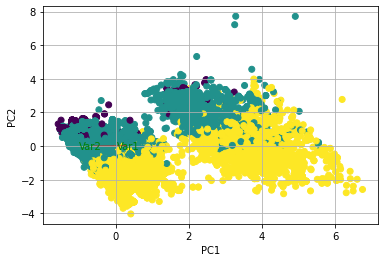

In [20]:
def pca_plot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c =ydata[:20000]) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

### Call the function. 
pca_plot(x_new[:,0:2], pca. components_) 
plt.show()

- From the PCA analysis of the dataset, the majority of variance in the model is in the 1st principle component. It is of no great surprise that potentially, total spend is sufficient to predict the basket size label. From visualisation of the principle components, the labels are well separated/clustered, facilitating machine learning. The bimodal appearance of the data requires further investigation.

### Additional training data using 'Country' as label

In [21]:
scaler = StandardScaler()
scaler.fit(xdata[:20000])
X=scaler.transform(xdata[:20000])

pca = PCA(n_components=2)
pca.fit(X,ydata)
x_new = pca.transform(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

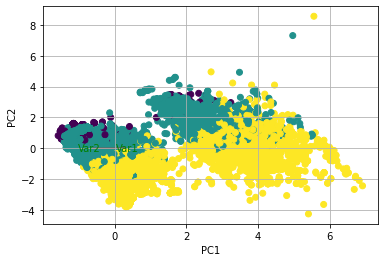

In [22]:
def pca_plot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c =ydata[:20000]) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

### Call the function. 
pca_plot(x_new[:,0:2], pca. components_) 
plt.show()

### Data preparation for training country of origin

In [23]:
### Encode the Description label
cols_to_transform = ['Description']
type_hash = pd.get_dummies(data=data2['Description'])

In [24]:
learning_data2 = pd.concat([data2, type_hash], axis=1)

In [25]:
learning_data2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,spend_label,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 BIRDS CANVAS SCREEN,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 PINK HEN+CHICKS IN BASKET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 RAFFIA RIBBONS VINTAGE CHRISTMAS,...,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP SUMMER ROSE DESIGN,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN","WRAP, CAROUSEL",YELLOW BREAKFAST CUP AND SAUCER,YELLOW COAT RACK PARIS FASHION,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
221722,556267,16216,LETTER SHAPE PENCIL SHARPENER,1600,2011-06-09 19:33:00,0.1,13694.0,United Kingdom,96.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
221744,556267,15034,PAPER POCKET TRAVELING FAN,1200,2011-06-09 19:33:00,0.1,13694.0,United Kingdom,84.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
371176,569214,15034,PAPER POCKET TRAVELING FAN,1200,2011-10-02 12:22:00,0.1,14533.0,United Kingdom,84.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
276441,561047,16045,POPART WOODEN PENCILS ASST,900,2011-07-24 12:46:00,0.0,16948.0,United Kingdom,36.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
513189,579538,20668,DISCO BALL CHRISTMAS DECORATION,864,2011-11-30 10:04:00,0.1,1

In [26]:
### Drop the columns that have been now been replaced and that are not required
droplist = ['Quantity','StockCode','InvoiceDate','InvoiceNo','UnitPrice','Description','spend_label','CustomerID']
learning_data2 = learning_data2.drop(droplist, axis=1)

In [27]:
learning_data2 = learning_data2.reset_index(drop=True)

In [28]:
xdata2 = learning_data2.copy()
del xdata2['Country']
ydata2 = learning_data2['Country']

In [29]:
### Convert ydata2 to integer
ydata2 = ydata2.astype('category')

In [30]:
normalized_xdata2 = preprocessing.normalize(xdata2)

### Machine learning - Predicting Customer Spend

In [31]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib ### For Saving the Trained Model

/Volumes/RaviVarma/DataScience/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



#### For the purposes of this work I will select a 70/30 split - 70% training data and 30% test data. This approach does not use a validation set however it provides a large dataset for training and testing. Cross validation of the training data set will also be used during model training.

In [32]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(normalized_xdata,ydata,test_size = 0.3, random_state = 8418) ### 70/30 training/test split - standard


#### Some helper functions for visualizing model output

In [33]:
import itertools

### Confusion Matrix plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Naive Bayes
- http://scikit-learn.org/stable/modules/naive_bayes.html
#### Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the 'naive' assumption of independence between every pair of features.
#### Naive bayes was chosen to build the 1st iteration of the model because it is a fast algorithm and requires no hyperparameters. This method will provide an indication of whether or not a model can be built using this dataset without using more computationally expensive methods.

In [34]:
from sklearn.naive_bayes import GaussianNB #choose model class - done
nb_model = GaussianNB() #instantiate the model - done (GaussianNB has no hyperparameters)
nb_model.fit(xtrain, ytrain) #fit the model to the data

GaussianNB(priors=None, var_smoothing=1e-09)

In [35]:
### Use the trained model to predict on the test data
predictions = list(nb_model.predict(xtest))

accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(ytest, predictions,average="micro")*100,"%")
print('Precision:', precision_score(ytest, predictions,average="micro")*100,"%")

Accuracy: 63.22%
Recall: 63.218118479128826 %
Precision: 63.218118479128826 %


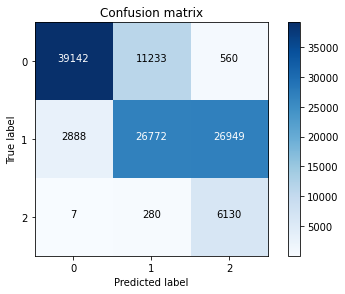

In [36]:
dat = confusion_matrix(ytest, predictions)

plot_confusion_matrix(
    dat, classes=[0,1,2], title='Confusion matrix')
plt.show()

In [37]:
### Save Model
#joblib.dump(nb_model, 'nb_model.pkl')

['nb_model.pkl']

In [35]:
### Load Model
nb_model = joblib.load('nb_model.pkl')

In [ ]:
xval_score = cross_val_score(nb_model, xtrain, ytrain, cv=5, n_jobs=-1).mean() ### 5-Fold Cross Validation

/Volumes/RaviVarma/DataScience/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [ ]:
xval_score